<table>
    <tr>
      <td>
      <img src='https://www.ideal-ist.eu/sites/default/files/2018-10/logo_quantum_flagship.jpg' width=450>
      </td>
      <td>
      <img src='https://newsroom.unl.edu/announce/files/file143411.jpg' width=310>
      </td>
      <td>
      <img src='https://www.akc.ac.cy/images/2022/03/Funded-by-the-European-Union.png' width=450>
      </td>
     </tr>
</table>

<div style="text-align: center; margin: 50px">

<h1 style="text-align: center;"><a href="https://qtom.qtedu.eu/shared-course/qtom-fridays-a-trip-through-the-world-of-quantum-technology/">QTOM Fridays – A trip through the world of Quantum Technology</a></h1> 
<h2 style="text-align: center;">Summer Semester 2022</h2>
<h2 style="text-align: center;"><a href="https://qt.eu/">European Union Quantum Flagship /</a> <a href="https://qtom.qtedu.eu/">QTEdu Quantum Technology Open Master</a></h2>
<h2 style="text-align: center;"><a href="https://www.ibm.com/quantum/">IBM Quantum </a></h2>
<h3><em>The device-independent scenario: Quantum Information Processing with Black Boxes</em>.</h3>
<h3>Anastasiia Andriievska</h3>

</div>

In [2]:
# Importing standard Qiskit libraries
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, Aer, IBMQ
from qiskit import Aer, execute, IBMQ, QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview
from qiskit.providers.aer import noise
from qiskit.circuit import Gate
from math import pi
import numpy as np
import matplotlib.pyplot as plt
import time

import warnings  # We are using this library to suppress some warning messages
warnings.filterwarnings("ignore")

print("Libraries imported successfully!")

sim = Aer.get_backend('aer_simulator')

# Set devices, if using a real device
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
quito = provider.get_backend('ibmq_quito')

Libraries imported successfully!


<h3>Bell inequalities</h3>
<h4>a) |CHSH| = 2 – This equation is the famous CHSH Bell inequality.</h4>

<h4>A quantum implementation of a CHSH Bell scenario in which the state prepared by the source is the two-qubit maximally entangled state, namely the First Bell State:</h4>

$$|\beta_{00}\rangle = \frac{1}{\sqrt{2}}\big(|00\rangle+|11\rangle\big)$$

<h4>Imagine Alice and Bob are given each one part of a bipartite entangled system. Each of them then performs two measurements on their part in two different bases.</h4>
<h4>Let's call Alice's bases $A$ and $a$ and Bob's $B$ and $b$.</h4>
<h4>Now, Alice and Bob have one qubit each, so any measurement they perform on their system (qubit) can only yield one of two possible outcomes: +1 or -1.</h4>
<h4>Note that whereas we typically refer to the two qubit states as $|0\rangle$ and $|1\rangle$, these are *eigenstates*, and a projective measurement will yield their *eigenvalues*, +1 and -1, respectively.</h4>
<h4>Therefore, if any measurement of $A$, $a$, $B$, and $b$ can only yield $\pm 1$, the quantities $(B-b)$ and $(B+b)$ can only be 0 or $\pm2$.</h4>
<h4>And thus, the quantity $A(B-b) + a(B+b)$ can only be either +2 or -2, which means that there should be a bound for the expectation value of the quantity we have called</h4>
<h4>$$|\langle CHSH \rangle| =|\langle AB \rangle - \langle Ab \rangle + \langle aB \rangle + \langle ab \rangle| \leq 2$$</h4>
<h4>The above discussion is oversimplified, because we could consider that the outcome on any set of measurements from Alice and Bob could depend on a set of local hidden variables, but it can be shown with some math that, even when that is the case, the expectation value of the quantity $CHSH$ should be bounded by 2 if local realism held. </h4>

<h4>b) But what happens when we compute these experiments with an entangled system?</h4>
<h4>First we are going to define a function to create our CHSH circuits. We are going to choose, without loss of generality, that Bob always uses the computational ($Z$) and the $X$ bases for his $B$ and $b$ measurements, respectively, whereas Alice chooses also orthogonal bases but whose angle we are going to vary between $0$ and $2\pi$ with respect to Bob's bases.</h4>
<h4>This set of angles is going to be the input argument to our $CHSH$ circuit building function.</h4>

Source: *IBM Qiskit Textbook 2022*.

In [4]:
def make_chsh_circuit(theta_vec):
    """Return a list of QuantumCircuits for use in a CHSH experiemnt
    (one for each value of theta in theta_vec)
    
        Args:
            theta_vec (list): list of values of angles between the bases of Alice and Bob
        
        Returns:
            List[QuantumCircuit]: CHSH QuantumCircuits for each value of theta
    """
    chsh_circuits = []
    
    for theta in theta_vec:
        obs_vec = ['00', '01', '10', '11']
        for el in obs_vec:
            qc = QuantumCircuit(2,2)
            qc.h(0)
            qc.cx(0, 1)
            qc.ry(theta, 0)
            for a in range(2):
                if el[a] == '1':
                    qc.h(a) 
            qc.measure(range(2),range(2))
            chsh_circuits.append(qc)

    return chsh_circuits  

<h4>Next, we are going to define a function for estimating the quantity $\langle CHSH \rangle$.</h4>
<h4>One can define two of such quantities, actually, $\langle CHSH1 \rangle = \langle AB \rangle - \langle Ab \rangle + \langle aB \rangle + \langle ab \rangle$ and $\langle CHSH2 \rangle = \langle AB \rangle + \langle Ab \rangle - \langle aB \rangle + \langle ab \rangle$.</h4>
<h4>Once chosen the corresponding measurement axes for both parties, each expectation value can be simply estimated by adding the counts from the output bitstrings with the appropriate sign plus for the even terms $00$ and $11$ and minus for odd terms $01$ and $10$.</h4>

In [5]:
def compute_chsh_witness(counts):
    """Computes expectation values for the CHSH inequality, for each
    angle (theta) between measurement axis.

        Args: counts (list[dict]): dict of counts for each experiment
              (4 per value of theta)

        Returns:
            Tuple(List, List): Tuple of lists with the two CHSH witnesses
    """
    # Order is ZZ,ZX,XZ,XX
    
    CHSH1 = []
    CHSH2 = []
    # Divide the list of dictionaries in sets of 4
    for i in range(0, len(counts), 4):  
        theta_dict = counts[i:i + 4]
        zz = theta_dict[0]
        zx = theta_dict[1]
        xz = theta_dict[2]
        xx = theta_dict[3]

        no_shots = sum(xx[y] for y in xx)

        chsh1 = 0
        chsh2 = 0

        for element in zz:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*zz[element]
            chsh2+= parity*zz[element]

        for element in zx:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*zx[element]
            chsh2-= parity*zx[element]

        for element in xz:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1-= parity*xz[element]
            chsh2+= parity*xz[element]

        for element in xx:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*xx[element]
            chsh2+= parity*xx[element]

        CHSH1.append(chsh1/no_shots)
        CHSH2.append(chsh2/no_shots)
    
    return CHSH1, CHSH2

<h4>Finally, we are going to split the interval $[0, 2\pi)$ into 15 angles and will build the corresponding set of $CHSH$ circuits.</h4>

In [6]:
number_of_thetas = 15
theta_vec = np.linspace(0,2*np.pi,number_of_thetas)
my_chsh_circuits = make_chsh_circuit(theta_vec)

<h4>Now, let's have a brief look at how four of these circuits look like for a given $\theta$.</h4>

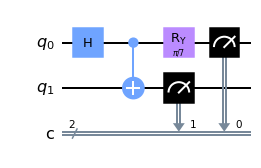

In [7]:
my_chsh_circuits[4].draw()

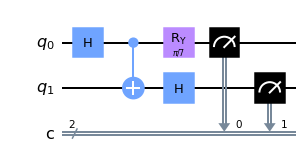

In [8]:
my_chsh_circuits[5].draw()

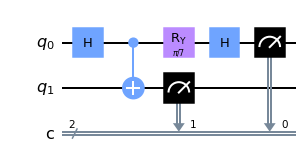

In [9]:
my_chsh_circuits[6].draw()

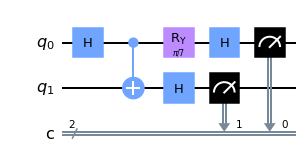

In [10]:
my_chsh_circuits[7].draw()

<h4>These circuits are simply creating a Bell pair, and then measuring each party in a different basis.</h4>
<h4>While Bob ($q_1$) always measures either in the computational basis or the $X$ basis, Alice's measurement basis rotates by the angle $\theta$ with respect to Bob's.</h4>

In [11]:
# Execute and get counts
result_ideal = sim.run(my_chsh_circuits).result()

tic = time.time()
transpiled_circuits = transpile(my_chsh_circuits, quito)
job_real = quito.run(transpiled_circuits, shots=8192)
job_monitor(job_real)
result_real = job_real.result()
toc = time.time()

print(toc-tic)

Job Status: job has successfully run
4222.0723092556


In [12]:
CHSH1_ideal, CHSH2_ideal = compute_chsh_witness(result_ideal.get_counts())
CHSH1_real, CHSH2_real = compute_chsh_witness(result_real.get_counts())

<h4>Now we plot the results.</h4>

Text(0, 0.5, 'CHSH witness')

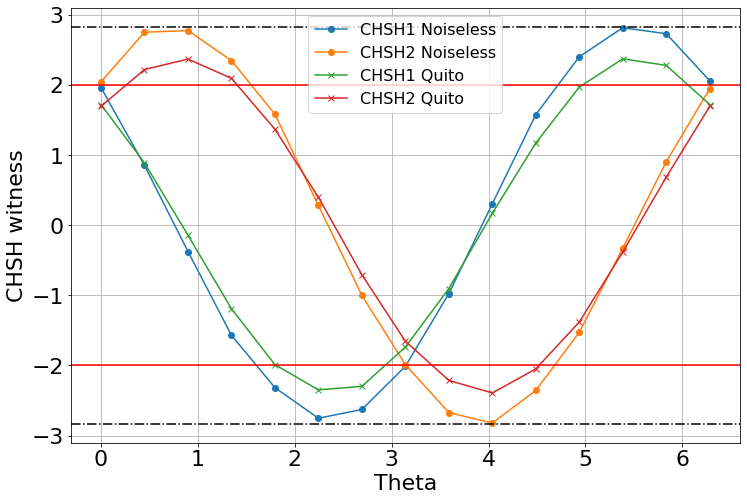

In [13]:
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 22})
plt.plot(theta_vec,CHSH1_ideal,'o-',label = 'CHSH1 Noiseless')
plt.plot(theta_vec,CHSH2_ideal,'o-',label = 'CHSH2 Noiseless')

plt.plot(theta_vec,CHSH1_real,'x-',label = 'CHSH1 Quito')
plt.plot(theta_vec,CHSH2_real,'x-',label = 'CHSH2 Quito')

plt.grid(which='major',axis='both')
plt.rcParams.update({'font.size': 16})
plt.legend()
plt.axhline(y=2, color='r', linestyle='-')
plt.axhline(y=-2, color='r', linestyle='-')
plt.axhline(y=np.sqrt(2)*2, color='k', linestyle='-.')
plt.axhline(y=-np.sqrt(2)*2, color='k', linestyle='-.')
plt.xlabel('Theta')
plt.ylabel('CHSH witness')

<h4>There are some particular combination of measurement bases for which $|CHSH| \geq 2$.</h4>
<h4>It is possible because it is easy to show that if $|\psi \rangle = 1/\sqrt{2} (|00\rangle + |11\rangle)$, then the expectation value $\langle AB \rangle = \langle \psi|A \otimes B| \psi \rangle = -\cos \theta_{AB}$ where $\theta_{AB}$ is the angle between the measurement bases $A$ and $B$.</h4>
<h4>Therefore, for the particular choice of bases $A = 1/\sqrt{2}(\sigma_z - \sigma_x)$ and $a = 1/\sqrt{2}(\sigma_z + \sigma_x)$, letting Bob measure with $B=\sigma_z$ and $b=\sigma_x$, we see that $|\langle CHSH1 \rangle| = 2\sqrt{2} > 2$.</h4>
<h4>It can also be shown that $2\sqrt{2}$ is the maximum possible value attainable, even in the quantum case (dash-dotted line in the plot).</h4>
<h4>The above inequality is called CHSH after Clauser, Horne, Shimony, and Holt, and it is the most popular way of presenting the original inequality from Bell.</h4>

<h4>c) Find the local bound of the inequality, in which the observables have a predetermined value equal to $\pm1$.</h4>
<h4>Having the same steps as before but involving three measurements by each of the two parties.</h4>

In [3]:
def make_chsh_circuit(theta_vec):
    """Return a list of QuantumCircuits for use in a CHSH experiemnt
    (one for each value of theta in theta_vec)
    
        Args:
            theta_vec (list): list of values of angles between the bases of Alice and Bob
        
        Returns:
            List[QuantumCircuit]: CHSH QuantumCircuits for each value of theta
    """
    chsh_circuits = []
    
    for theta in theta_vec:
        obs_vec = ['00', '01', '10', '11']
        for el in obs_vec:
            qc = QuantumCircuit(2,2)
            qc.h(0)
            qc.cx(0, 1)
            qc.ry(theta, 0)
            for a in range(2):
                if el[a] == '1':
                    qc.h(a) 
            qc.measure(range(2),range(2))
            # measure again
            qc.measure(range(2),range(2))
            qc.measure(range(2),range(2))
            chsh_circuits.append(qc)

    return chsh_circuits  

In [4]:
def compute_chsh_witness(counts):
    """Computes expectation values for the CHSH inequality, for each
    angle (theta) between measurement axis.

        Args: counts (list[dict]): dict of counts for each experiment
              (4 per value of theta)

        Returns:
            Tuple(List, List): Tuple of lists with the two CHSH witnesses
    """
    # Order is ZZ,ZX,XZ,XX
    
    CHSH1 = []
    CHSH2 = []
    # Divide the list of dictionaries in sets of 4
    for i in range(0, len(counts), 4):  
        theta_dict = counts[i:i + 4]
        zz = theta_dict[0]
        zx = theta_dict[1]
        xz = theta_dict[2]
        xx = theta_dict[3]

        no_shots = sum(xx[y] for y in xx)

        chsh1 = 0
        chsh2 = 0

        for element in zz:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*zz[element]
            chsh2+= parity*zz[element]

        for element in zx:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*zx[element]
            chsh2-= parity*zx[element]

        for element in xz:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1-= parity*xz[element]
            chsh2+= parity*xz[element]

        for element in xx:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*xx[element]
            chsh2+= parity*xx[element]

        CHSH1.append(chsh1/no_shots)
        CHSH2.append(chsh2/no_shots)
    
    return CHSH1, CHSH2

In [5]:
number_of_thetas = 15
theta_vec = np.linspace(0,2*np.pi,number_of_thetas)
my_chsh_circuits = make_chsh_circuit(theta_vec)

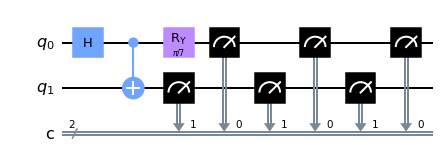

In [6]:
my_chsh_circuits[4].draw()

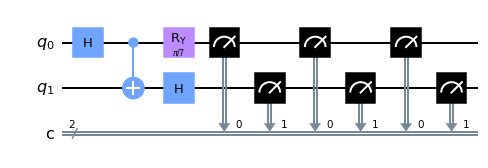

In [7]:
my_chsh_circuits[5].draw()

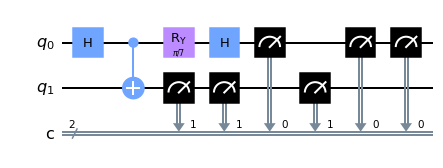

In [8]:
my_chsh_circuits[6].draw()

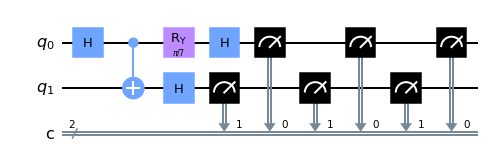

In [9]:
my_chsh_circuits[7].draw()

In [10]:
# Execute and get counts
result_ideal = sim.run(my_chsh_circuits).result()

tic = time.time()
transpiled_circuits = transpile(my_chsh_circuits, quito)
job_real = quito.run(transpiled_circuits, shots=8192)
job_monitor(job_real)
result_real = job_real.result()
toc = time.time()

print(toc-tic)

Job Status: job has successfully run
4508.4673619270325


In [11]:
CHSH1_ideal, CHSH2_ideal = compute_chsh_witness(result_ideal.get_counts())
CHSH1_real, CHSH2_real = compute_chsh_witness(result_real.get_counts())

<h4>Now we plot the results.</h4>

Text(0, 0.5, 'CHSH witness')

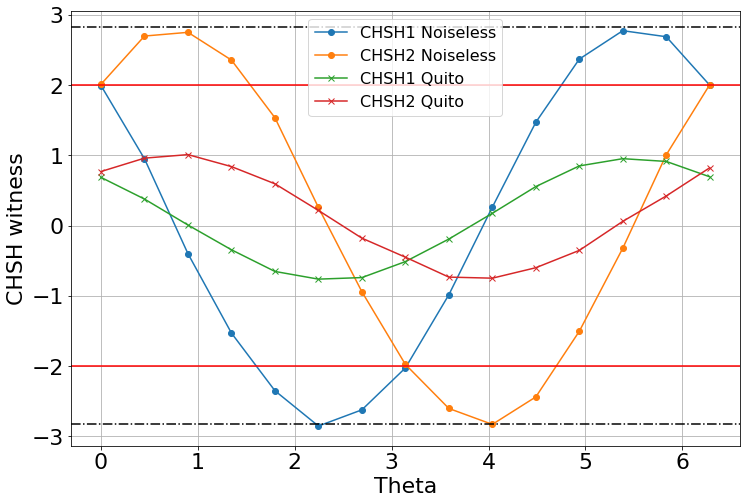

In [12]:
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 22})
plt.plot(theta_vec,CHSH1_ideal,'o-',label = 'CHSH1 Noiseless')
plt.plot(theta_vec,CHSH2_ideal,'o-',label = 'CHSH2 Noiseless')

plt.plot(theta_vec,CHSH1_real,'x-',label = 'CHSH1 Quito')
plt.plot(theta_vec,CHSH2_real,'x-',label = 'CHSH2 Quito')

plt.grid(which='major',axis='both')
plt.rcParams.update({'font.size': 16})
plt.legend()
plt.axhline(y=2, color='r', linestyle='-')
plt.axhline(y=-2, color='r', linestyle='-')
plt.axhline(y=np.sqrt(2)*2, color='k', linestyle='-.')
plt.axhline(y=-np.sqrt(2)*2, color='k', linestyle='-.')
plt.xlabel('Theta')
plt.ylabel('CHSH witness')

<h4>There are some particular local bound of the inequality, in which the observables have a predetermined value equal to $\pm1$.</h4>

<h4>d) Find the quantum value when considering the maximally entangled state and observables $A_i$ and $B_i$.</h4>
<h4>A related entanglement-based protocol is $E91$ or $Ekert91$ protocol, invented by Artur Ekert in 1991.</h4>
<h4>In this protocol, a transmitter consisting of an entanglement source generates a two-photon entangled state known as a</h4>
<h4>$Maximally$ $entangled$ $Bell$ $state$, with one photon being sent to Alice and the other photon being sent to Bob.</h4>
<h4>The photons are sent across quantum communication channels that can reliably transmit the single-photon states and preserve their entanglement.</h4>
<h4>The relevant property of Bell states is that the photons are $correlated$ $in$ $multiple$ $measurement$ $base$.</h4>
<h4>For an ideal transmission across the channel, if Alice and Bob choose the same measurement basis, their measurement results will be perfectly correlated between the measurement devices, but individual measurements at each side will look random.</h4>
<h4>Alternately, if Alice chooses, say, $\{|0\rangle, |1\rangle\}$ basis and Bob chooses the $\{|+\rangle, |-\rangle\}$ measurement basis, the measurements will not be correlated at all. And for intermediate basis choices, their measurements will be $partly$ $correlated$.</h4>
<h4>The E91 protocol is based on the use of entangled states and Bell's theorem.</h4>
<h4>As an entangled state can be used one of the Bell states, e.g., the singlet state</h4>

$$\lvert\Psi^-\rangle =
  \frac{1}{\sqrt{2}}(\lvert0\rangle_A\otimes\lvert1\rangle_B - \lvert1\rangle_A\otimes\lvert0\rangle_B) =
  \frac{1}{\sqrt{2}}(\lvert01\rangle - \lvert10\rangle),$$
  
<h4>An observable for a single qubit can be defined by a direction $\vec{n}=(n_x, n_y, n_z)$ on the Bloch sphere as</h4>

$$\vec{n} \cdot \vec{\sigma} = 
n_x X + n_y Y + n_z Z,$$

<h4>where $\vec{\sigma} = (X, Y, Z)$ and $X, Y, Z$ are the Pauli matrices.</h4>
<h4>For two qubits *A* and *B*, the observable $(\vec{a} \cdot \vec{\sigma})_A \otimes (\vec{b} \cdot \vec{\sigma})_B$ describes the joint measurement, defined by the directions $\vec{a}$ and $\vec{b}$.</h4>
<h4>It can be shown that the expectation value of this observable in the singlet state is</h4>

$$\langle (\vec{a} \cdot \vec{\sigma})_A \otimes (\vec{b} \cdot \vec{\sigma})_B \rangle_{\psi_s} =
-\vec{a} \cdot \vec{b}.$$

<h4>Here we see an interesting fact: if Alice and Bob measure the observables A and B deifined by the same directions, they will obtain the opposite results.</h4>
<h4>Thus, if Alice got the result $\pm 1$, then Bob *with $100\%$ certainty* will get the result $\mp 1$, i.e. the results will be perfectly anticorrelated.</h4>

<h4>e) The inequality can be generalized to an arbitrary number of measurements n.</h4>
<h4>If the amount of violation of Bell inequalities is used to quantify nonlocality, this amount of violation must thus first be normalized in some proper way..</h4>
<h4>If this normalization is well chosen, one can then often relate the amount of violation of Bell inequalities to an operational measure of nonlocality.</h4>
<h4>Taking the ratio and the absolute value is crucial for a meaningful definition of this amount of violation.</h4>
<h4>If instead of the ratio one takes for instance the difference, a change of scale s → γs would lead to $arbitrary$ violations.</h4>
<h4>If one removes instead the absolute value, the same happens via an offset.</h4>
Sources: https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.86.419

<h4>f) Threshold efficiencies have also been derived for certain multipartite Bell tests (with n parties), using qubit GHZ states.</h4>
<h4>Based on a combinatorial study, Buhrman et al. (2003) showed that an arbitrarily small efficiency can be tolerated as n becomes large.</h4>
<h4>Threshold efficiencies approaching 50% in the limit of a large n were demonstrated for the Mermin inequalities (Cabello, Rodriguez, and Villanueva, 2008) and for a multipartite generalization of the CH inequality (Larsson and Semitecolos, 2001).</h4>
<h4>More recently, multipartite Bell tests tolerating efficiencies significantly below 50% were reported by Pal, Ve´rtesi, and Brunner (2012).</h4>
Sources: https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.91.047903<br>
         https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.101.120402<br>
         https://journals.aps.org/pra/abstract/10.1103/PhysRevA.63.022117<br>
         https://journals.aps.org/pra/abstract/10.1103/PhysRevA.86.062111

<h4>g) The value of p such that the local and quantum value coincide.</h4>
<h4>For mixed states, a necessary and sufficient condition for any two-qubit state to violate the CHSH inequality was given by Horodecki (1995). This criterion works as follows. Associate with any two-qubit state $\rho$ a correlation matrix $T_\rho$ with entries $t_{i,j} = tr \lbrack\rho(\sigma_i\otimes\sigma_j)\rbrack $ for $i, j = 1, 2, 3$ where $\sigma_i$ are the Pauli matrices.</h4>
<h4>The maximum CHSH value $S$ for $\rho$ (considering the most general measurements) is then simply given by:</h4>
$$S_\rho = 2\sqrt{m_{11}^2 + m_{22}^2}$$
<h4>Not every entangled two-qubit mixed state violates the CHSH inequality.In particular, there exist two-qubit states which do not violate</h4>
<h4>CHSH, but violate a more sophisticated Bell inequality. One example is the maximally mixed state, i.e.</h4>
$$\rho_W = p|\phi_+\rangle\langle\phi_+| + (1 - \rho) \frac{1}{4} $$
<h4>where $m_{11}^2$ and + $m_{22}^2$ are the two largest eigenvalues of the matrix $T_{\rho}T_{\rho}^{T}$. Using the above criterion, it is possible to relate the entanglement of $\rho$, as
measured by its concurrence to its maximal violation of CHSH (Verstraete and Wolf, 2002).</h4>
Sources: https://doi.org/10.1016/0375-9601(95)00214-N<br>
         https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.89.170401<br>

In [1]:
import qiskit.tools.jupyter
%qiskit_version_table

Copyright 2023 Anastasiia Andriievska

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License